In [1]:
import pandas as pd
import numpy as np
#import eikon as ek
import sys
#import config
#ek.set_app_key(config.eikon_key)
import cufflinks as cf
import configparser as cp
cf.set_config_file(offline = True)
from datetime import datetime
from datetime import timedelta
#import DatastreamDSWS as DSWS
#ds = DSWS.Datastream(username = 'JGarden1@lidoadvisors.com', password= 'Welcome2')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import altair as alt
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import chart_studio
from chart_studio.plotly import plot, iplot
import chart_studio.plotly as py
from PIL import Image as im
#import Lido_funcs3 as lf
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import validation_curve
import IPython.display
from IPython.display import Image
chart_studio.tools.set_credentials_file(username='JGarden79', api_key='eWGoAmjzRp3GIVRTFfSR')
from sklearn.model_selection import GridSearchCV
import chart_studio.tools as tls

import plotly.io as pio
from sklearn.model_selection import StratifiedKFold

import plotly.figure_factory as ff
from sklearn.metrics import classification_report

from plotly.subplots import make_subplots
import scipy.stats as st

In [2]:
def get_data_SECT_1():
    '''Calls Data from Datastream web services and stores in a csv. This will not run without a Thomson Reuters 
    Terminal running as well as a subscription to both TR and DS'''
    raw = ds.get_data(tickers='USSPRPER, TRUS10T, TRUS3MT, USCPCOREE, USUN%TOTQ, USCNFBUSQ, USNBERBCR, USPERCONB, USUMCONSH', start='BDATE', fields='X', freq='M').dropna()
    raw = raw.droplevel(level = 1, axis = 1)
    raw.columns=raw.columns.rename('')
    clean = raw.rename(columns = {"USSPRPER": 'Valuation', ' TRUS10T': 'ten_yr', ' TRUS3MT': 'three_mth', ' USCPCOREE': 'Core_INF',
                                  ' USUN%TOTQ':'Unemployment',
                                  ' USCNFBUSQ': 'PMI', ' USPERCONB': 'Personal Consump', ' USUMCONSH': 'UMICH Sent', ' USNBERBCR': 'Recession',})
    clean.to_csv('Section_1_DATA.csv')
    
    funds = ds.get_data(tickers='519793, 519822', start='BDATE', fields=['RI'], freq='M').dropna()
    funds = funds.droplevel(level = 1, axis = 1)
    funds.columns = funds.columns.rename('')
    funds = funds.rename(columns = {'519793': 'Vanguard Total Bond', ' 519822': 'Vanguard 500 Stock'})
    funds.to_csv('Sect_1_Funds.csv')
    
    return 

In [3]:
#get_data_SECT_1()

In [4]:
def data_processing_1(df):
    df = pd.read_csv(df)
    twlv = df['Recession'].shift(-12).replace(np.nan, 0.0)
    twlv = twlv.rename('12_to_rec')
    clean = df.join(twlv)
    clean = clean.dropna()
    clean['Dates'] = pd.to_datetime(clean['Dates'])
    clean = clean.set_index('Dates')
    clean['inf_adj'] = clean['Core_INF'].pct_change(12)
    clean['Slope'] = (clean['ten_yr'] - clean['three_mth'])
    clean = clean.drop(['ten_yr', 'three_mth'], axis = 1)
    clean['Valuation'] = (clean['Valuation'] - clean['Valuation'].expanding(36).mean())/clean['Valuation'].expanding(36).std()
    clean['inf_adj'] = (clean['inf_adj'] - clean['inf_adj'].rolling(36).mean())/clean['inf_adj'].rolling(36).std()
    clean = clean.drop('Core_INF', axis = 1)
    clean['Employment'] = 100 - clean['Unemployment']
    clean['Employment'] = (clean['Employment'] - clean['Employment'].expanding(36).mean())/clean['Employment'].expanding(36).std()
    clean = clean.drop('Unemployment', axis = 1)
    clean['PMI'] = (clean['PMI'] - clean['PMI'].expanding(36).mean())/clean['PMI'].expanding(36).std()
    clean['Personal Consump'] = clean['Personal Consump'].pct_change(12)
    clean['Personal Consump'] = (clean['Personal Consump'] - clean['Personal Consump'].expanding(36).mean())/clean['Personal Consump'].expanding(36).std()
    clean['UMICH Sent'] = (clean['UMICH Sent'] - clean['UMICH Sent'].expanding(36).mean())/clean['UMICH Sent'].expanding(36).std()
    clean['Slope'] = (clean['Slope'] - clean['Slope'].expanding(36).mean())/clean['Slope'].expanding(36).std()
    return clean.dropna()

In [5]:
df = data_processing_1('Section_1_DATA.csv')

In [6]:
def feature_prep_1(df):
    df = df
    X = df.drop(['Recession', '12_to_rec'], axis = 1)
    y = df['12_to_rec']
    X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42, test_size = 1/2)
    
    return X, y, X_train, X_test, y_train, y_test

In [7]:
X, y, X_train, X_test, y_train, y_test = feature_prep_1(df)

In [8]:
def model_selection(X, y, X_train, X_test, y_train, y_test):
    param_range = [0.01, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

    
    clf = LogisticRegression(random_state = 42)
    param_grid = dict(C=param_range)
    kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    grid_search = GridSearchCV(clf, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
    grid_result = grid_search.fit(X,y)
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    
    C = grid_result.best_params_
    C = C['C']
    clf= LogisticRegression(random_state = 42,C = C).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=['not 1', '1']))
    y_score_clf = clf.fit(X_train, y_train).decision_function(X_test)
    fpr_clf, tpr_clf, _ = roc_curve(y_test, y_score_clf)
    roc_auc_clf = auc(fpr_clf, tpr_clf)
    
    
    fig = px.area(
        x=fpr_clf, y=tpr_clf,
        title=f'Precision-Recall Curve<br>Logisitic Reg(AUC={auc(fpr_clf, tpr_clf):.4f})',
        labels=dict(x='Recall', y='Precision'),
        width=250, height=250
    )
    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=0, y1=1
    )
    fig.update_yaxes( automargin=True)
    fig.update_xaxes(constrain='domain')
    fig.update_layout(font=dict(
            size=9,
            color="Black"), margin=dict(
            l=1,
            r=1,
            b=1,
            t=50,
            pad=0,
        ))
    
    fig.show()
    return C
    

Best: -0.284203 using {'C': 0.2}
-0.326840 (0.003939) with: {'C': 0.01}
-0.286042 (0.023841) with: {'C': 0.1}
-0.284203 (0.031223) with: {'C': 0.2}
-0.284306 (0.034886) with: {'C': 0.3}
-0.284646 (0.037109) with: {'C': 0.4}
-0.284985 (0.038613) with: {'C': 0.5}
-0.285287 (0.039703) with: {'C': 0.6}
-0.285544 (0.040528) with: {'C': 0.7}
-0.285763 (0.041176) with: {'C': 0.8}
-0.285951 (0.041699) with: {'C': 0.9}
-0.286114 (0.042130) with: {'C': 1}
              precision    recall  f1-score   support

       not 1       0.88      0.99      0.93       235
           1       0.00      0.00      0.00        31

    accuracy                           0.88       266
   macro avg       0.44      0.50      0.47       266
weighted avg       0.78      0.88      0.83       266



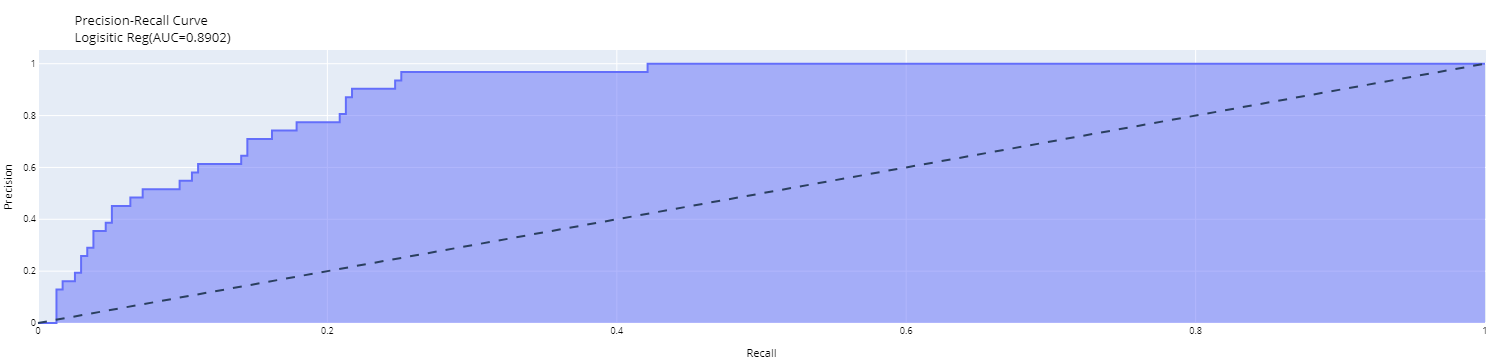

In [9]:
C = model_selection(X, y, X_train, X_test, y_train, y_test)

In [10]:
def model_1(X_train, X_test, y_train, y_test, C):
    '''Trains model using different learning rates and estimators, selects model with best f1 score.'''
        
    clf =  LogisticRegression(random_state = 42, C = C).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    f_1_fin = f1_score(y_test, y_pred, average = 'micro')
    print(C, f_1_fin)
 
    return clf
    

In [11]:
clf = model_1( X_train, X_test, y_train, y_test, C)

0.2 0.8759398496240601


In [12]:
def perfomance_bt(funds, clf, X, indc):
    funds = pd.read_csv(funds)
    indicator = clf.predict_proba(X)[:,1]
    df_vis = df
    df_vis['indicator'] = indicator
    funds = funds.set_index('Dates')
    funds  = funds.join(df_vis['indicator'])
    funds = funds.join(df_vis['Recession'])
    #funds['indicator'] = funds['indicator'].ewm(span = 4).mean()
    funds = funds.replace(np.nan, 0)
    stock = funds['Vanguard 500 Stock'].to_list()
    bonds = funds['Vanguard Total Bond'].to_list()
    indicator = funds['indicator'].to_list()
    values = []
    b_vals = []
    e_vals = []
    stock_shares = 60000/stock[0]
    bond_shares = 40000/bonds[0]
    stock_val = stock_shares * stock[0]
    bond_val = bond_shares * bonds[0]
    port_val = 100000
    for i in range(0, len(indicator)):
    ####Set Share Counts
        if i < 6:
            stock_val = stock_shares * stock[i]
            bond_val = bond_shares * bonds[i]
            port_val = stock_val+bond_val
            values.append(port_val)
        else:
            if indicator[i] < 0.2 and indicator[i-1] < 0.2 and indicator[i-2] < 0.2 and indicator[i-3] < 0.2 and indicator[i-4] < 0.2 and indicator[i-5] < 0.2:
                if stock_val > bond_val:
                    stock_val = stock_shares * stock[i]
                    bond_val = bond_shares * bonds[i]
                    port_val = stock_val+bond_val
                    values.append(port_val)
                else:
                    stock_val = 0.6 * port_val
                    bond_val = 0.4 * port_val
                    stock_shares = stock_val/stock[i]
                    bond_shares = bond_val/bonds[i]
                    stock_val = stock_shares * stock[i]
                    bond_val = bond_shares * bonds[i]
                    port_val = stock_val+bond_val
                    values.append(port_val)
            else:
                if stock_val < bond_val:
                    stock_val = stock_shares * stock[i]
                    bond_val = bond_shares * bonds[i]
                    port_val = stock_val+bond_val
                    values.append(port_val)
                else:
                    stock_val = 0.4 * port_val
                    bond_val = 0.6 * port_val
                    stock_shares = stock_val/stock[i]
                    bond_shares = bond_val/bonds[i]
                    stock_val = stock_shares * stock[i]
                    bond_val = bond_shares * bonds[i]
                    port_val = stock_val+bond_val
                    values.append(port_val)                
        e_vals.append(stock_val)
        b_vals.append(bond_val)
    
    
    stock_shares = 60000/stock[0]
    bond_shares = 40000/bonds[0]    
    funds['Active'] = values
    funds['Buy_hold'] = (funds['Vanguard Total Bond'] * bond_shares) + (funds['Vanguard 500 Stock'] * stock_shares)
    funds['Active_perf'] = (funds['Active']/funds['Active'].iloc[0])
    funds['Buy_hold_perf'] = (funds['Buy_hold']/funds['Buy_hold'].iloc[0])
    funds['Active'] = funds['Active'].pct_change()
    funds['Buy_hold'] = funds['Buy_hold'].pct_change()
    funds['Stock_alloc'] = e_vals
    funds['Bond_alloc'] = b_vals
    funds = funds.replace(np.nan, 0)

    
    
    return funds

In [13]:
bt_res = perfomance_bt('Sect_1_Funds.csv', clf, X, df)

In [14]:
def alloc_plot(bt):
    funds = bt
    dates = funds.index.to_list()
    idc = funds['indicator'].to_list()
    recs = funds['Recession'].to_list()
    e_vals = funds['Stock_alloc'].to_list()
    b_vals = funds['Bond_alloc'].to_list()
    evaluation_df = pd.DataFrame({'Dates': dates, 'Stock_alloc': e_vals, 'Bond_alloc': b_vals, 'Sig': idc, 'Recess': recs})
    evaluation_df['Total'] = evaluation_df['Stock_alloc'] + evaluation_df['Bond_alloc']
    evaluation_df['Stock (%)'] = evaluation_df['Stock_alloc'] /evaluation_df['Total']
    evaluation_df['Bond (%)'] = 1-evaluation_df['Stock (%)']
    fig_alloc = go.Figure()
    fig_alloc.add_trace(go.Scatter(
        x= evaluation_df['Dates'],
        y = evaluation_df['Stock (%)'],
        line=dict(width=0.5, color='#FFCB05'),
        name = 'Allocation to Stocks',
        stackgroup = 'one'))

    fig_alloc.add_trace(go.Scatter(
        x= evaluation_df['Dates'],
        y = evaluation_df['Bond (%)'],
        line=dict(width=0.5, color='#00274C'),
        name = 'Allocation to Bonds',
        stackgroup = 'one'))

    fig_alloc.add_trace(go.Scatter(
        x= evaluation_df['Dates'],
        y = evaluation_df['Sig'],
        line=dict(width=3, color='#9A3324'),
        name = 'Signal'))

    fig_alloc.update_yaxes(tickformat=".2%")

    fig_alloc.update_layout(legend=dict(orientation='h',yanchor='top',xanchor='center',y=-0.05, x=0.5), paper_bgcolor='white',
        plot_bgcolor='white' , height = 800, width = 1200, title_text='Change in Allocation Over Time', title_x=0.5)


    
    
    
    return fig_alloc

In [15]:
def perf_plot(bt):
    funds = bt
    funds = funds.reset_index()
    portfolios = funds.filter(['Dates', 'Active_perf', 'Buy_hold_perf', 'indicator', 'Recession'])
    portfolios['Active_perf'] = portfolios['Active_perf']-1
    portfolios['Buy_hold_perf'] = portfolios['Buy_hold_perf']-1
    fig_perf =  make_subplots(specs=[[{"secondary_y": True}]])

    fig_perf.add_trace(
        go.Scatter(
        x = portfolios['Dates'],
        y = portfolios['indicator'],
        name = 'Signal',
        line = {'color': '#9A3324'}))

    fig_perf.add_trace(
        go.Bar(
        x = portfolios['Dates'],
        y = portfolios['Recession'],
        name = 'US Recession',
    marker = {'color': '#989C97', 'line': {'width': 5}, 'opacity':0.5}))



    fig_perf.add_trace(
        go.Scatter(
        x = portfolios['Dates'],
        y = portfolios['Active_perf'],
        name = 'Active Portfolio',
        line = {'color': '#FFCB05'}),secondary_y=True)

    fig_perf.add_trace(
        go.Scatter(
        x = portfolios['Dates'],
        y = portfolios['Buy_hold_perf'],
        name = '60/40 Buy & Hold Portfolio',
        line = {'color': '#00274C'}), secondary_y=True)

    fig_perf.update_yaxes(tickformat=".2%", title = 'Probability of Recession in 12 Months')
    fig_perf.update_yaxes(tickformat=".2%", secondary_y=True, title = 'Portfolio Return')




    fig_perf.update_layout(legend=dict(orientation='h',yanchor='top',xanchor='center',y=-0.05, x=0.5), paper_bgcolor='white',
        plot_bgcolor='white' , height = 800, width = 1200, title_text='Performance', title_x=0.5)
    
    mu_a = funds['Active'].mean() * 12
    sig_a = funds['Active'].std() * (12**0.5)
    mu_b = funds['Buy_hold'].mean() * 12
    sig_b = funds['Buy_hold'].std() * (12**0.5)

    active_sharpe = (mu_a-0.02)/sig_a
    bh_sharpe = (mu_b-0.02)/sig_b
    print('Active Portfolio Sharpe: {:.2f}'.format(active_sharpe))
    print('60/40 Buy and Hold Sharpe: {:.2f}'.format(bh_sharpe))

    return fig_perf


In [16]:
def get_factor_plots(indc):
    df_polar = indc.drop(['indicator', '12_to_rec', 'Recession'], axis = 1)
    df_polar = df_polar.reset_index()
    for i in df_polar.columns:
        try:
            df_polar[i] = st.norm.cdf(df_polar[i])
        except:
            pass

    df_polar['Slope'] = 1-df_polar['Slope']
    df_polar['PMI'] = 1-df_polar['PMI']
    df_polar['Personal Consump'] = 1-df_polar['Personal Consump']
    df_polar['Dates']= df_polar['Dates'].dt.strftime('%Y-%m-%d')
    df_polar =df_polar.set_index('Dates') 
    
    peak_dates = ['1990-02-28', '2000-09-29', '2007-05-31', '2008-04-30','2019-09-30', '2020-11-30' ]
    colors = ['#9A3324', '#75988d', '#00B2A9', '#702082', '#CFC096', '#989C97', '#655A52']
    pix = dict()
    for i in  peak_dates:
        x = list(df_polar.columns)
        y = list(df_polar.loc[i])
        y_text= ['{:.2%}'.format(i) for i in y]
        fig = go.Figure(data=[go.Bar(x=x, y=y, text = y_text, textposition="inside",
                                marker_color=colors)])
        fig.update_yaxes(tickformat=".2%", range=[0,1])
        fig.update_layout(title_text = 'Factor Scores as of {}'.format(i), paper_bgcolor='white',
        plot_bgcolor='white' , height = 500, width = 890, title_x=0.5)
        pix[i] = fig

    
    
    
    
    return pix

Active Portfolio Sharpe: 0.89
60/40 Buy and Hold Sharpe: 0.69


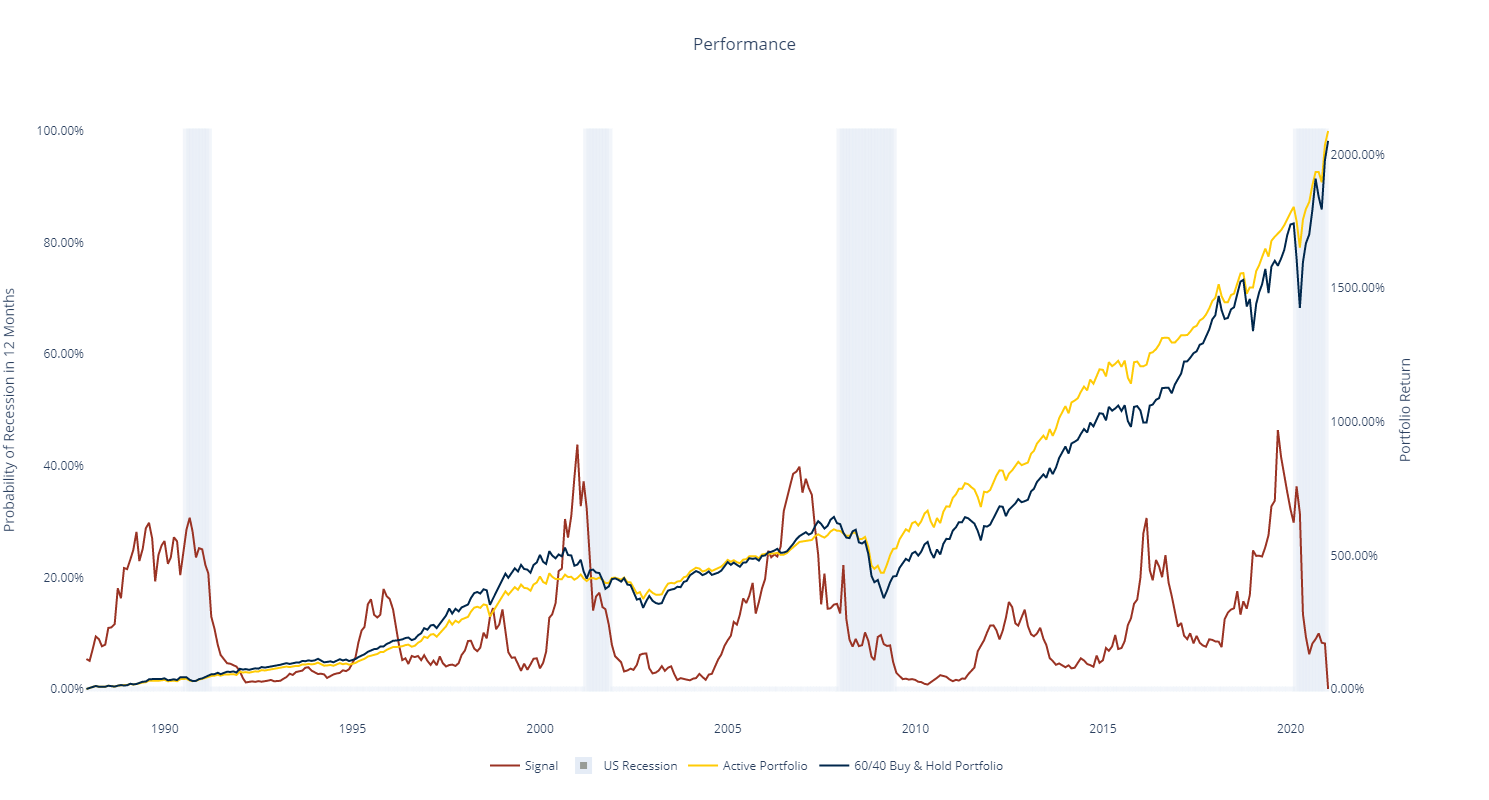

In [17]:
perf_plot(bt_res)

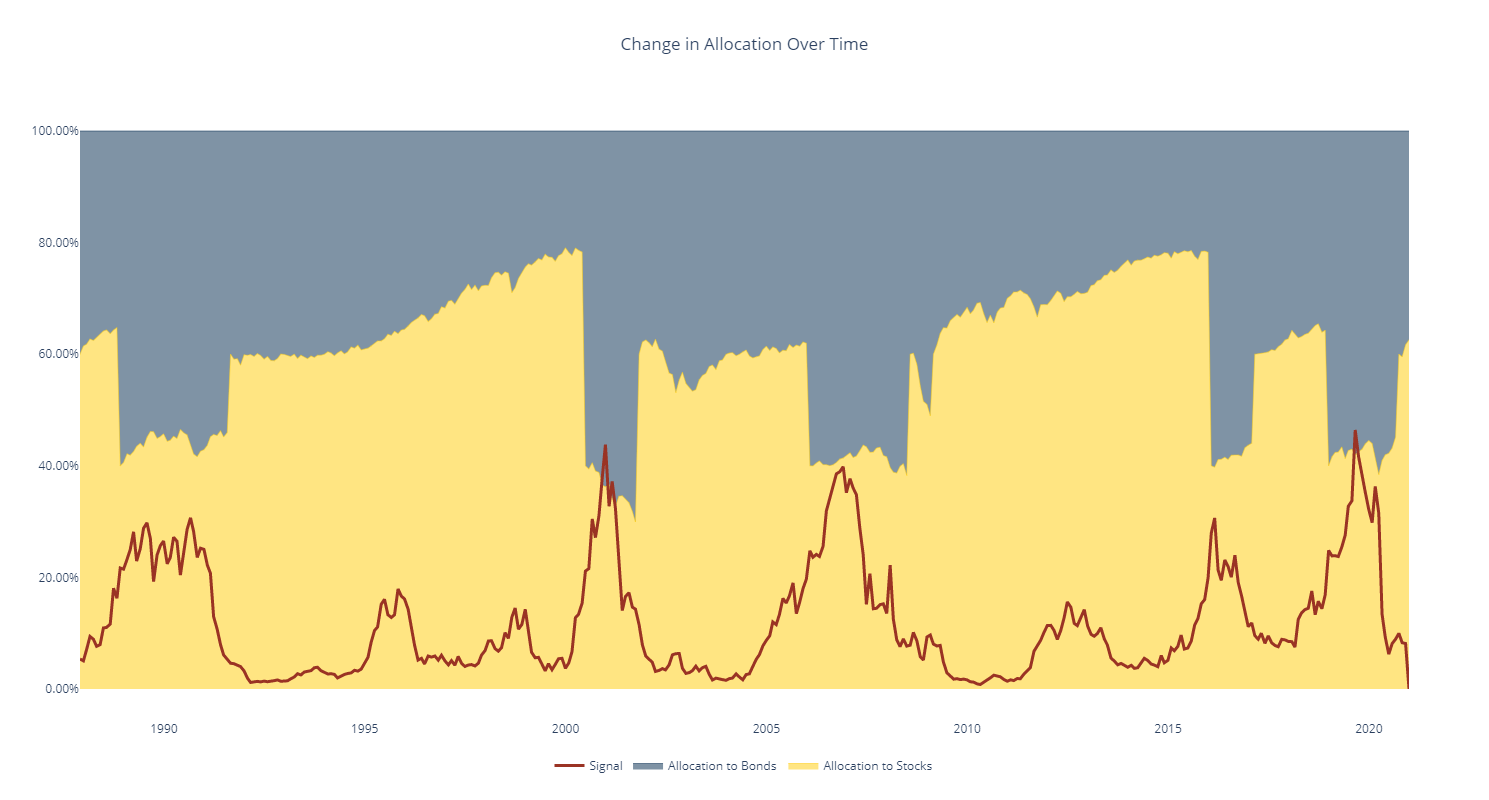

In [18]:
alloc_plot(bt_res)

In [19]:
k = get_factor_plots(df)

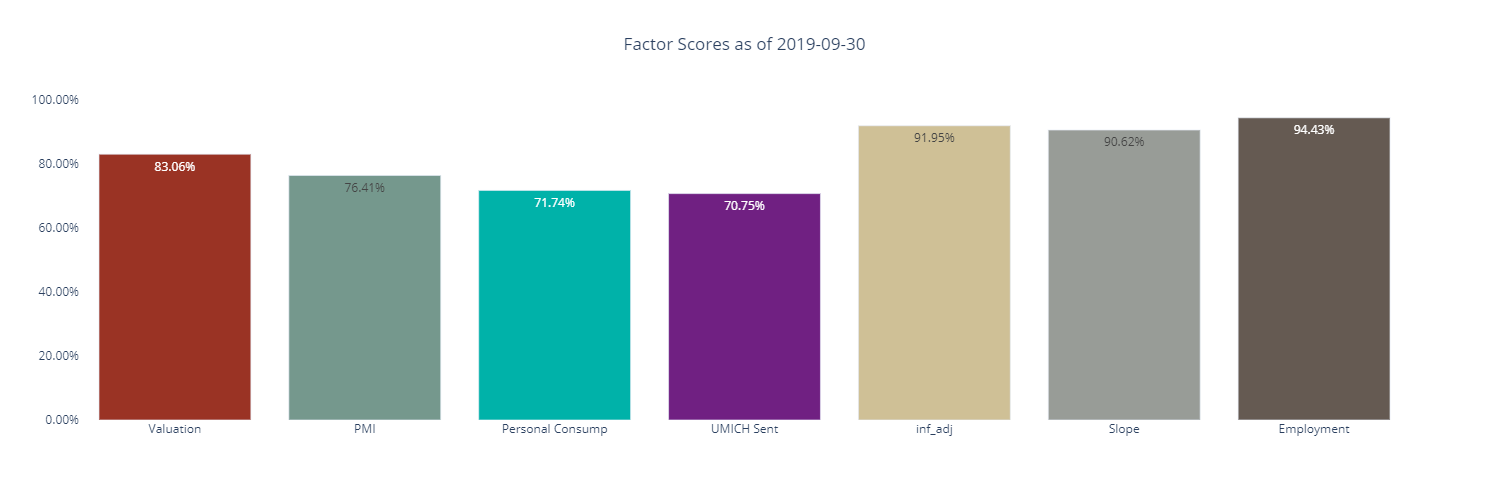

In [20]:
k['2019-09-30']

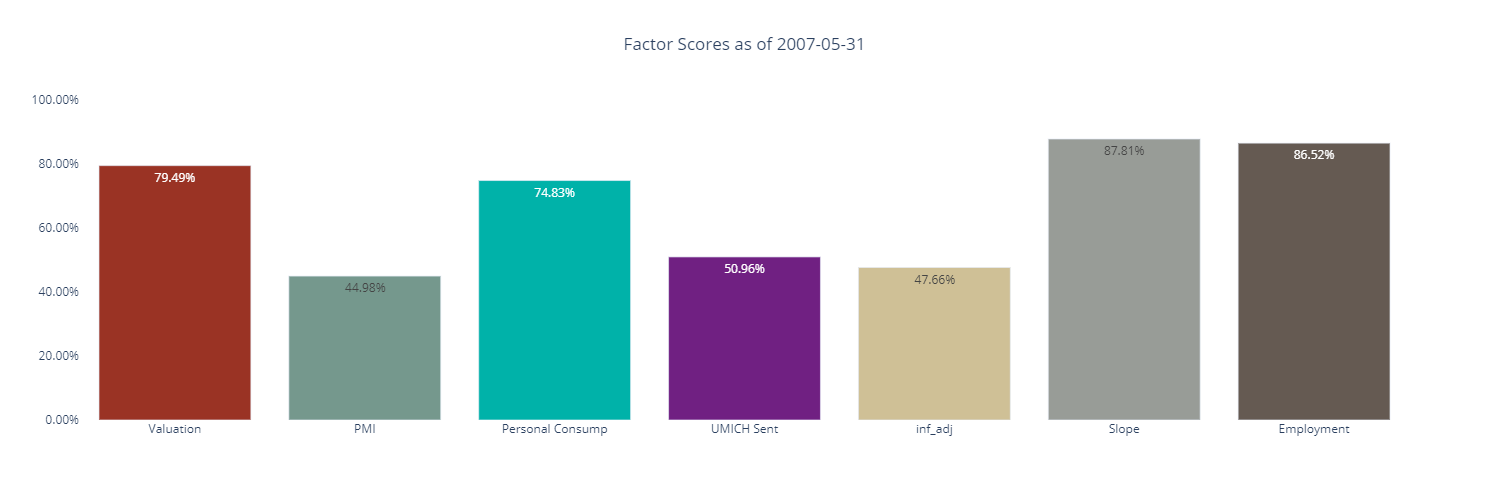

In [21]:
k['2007-05-31']

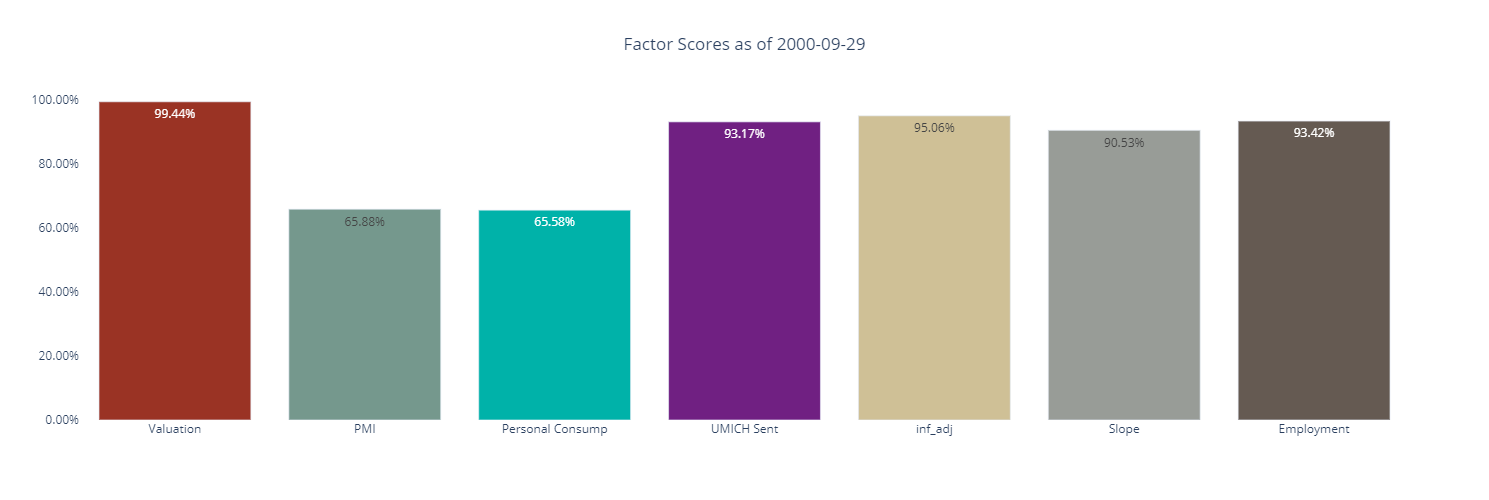

In [22]:
k['2000-09-29']

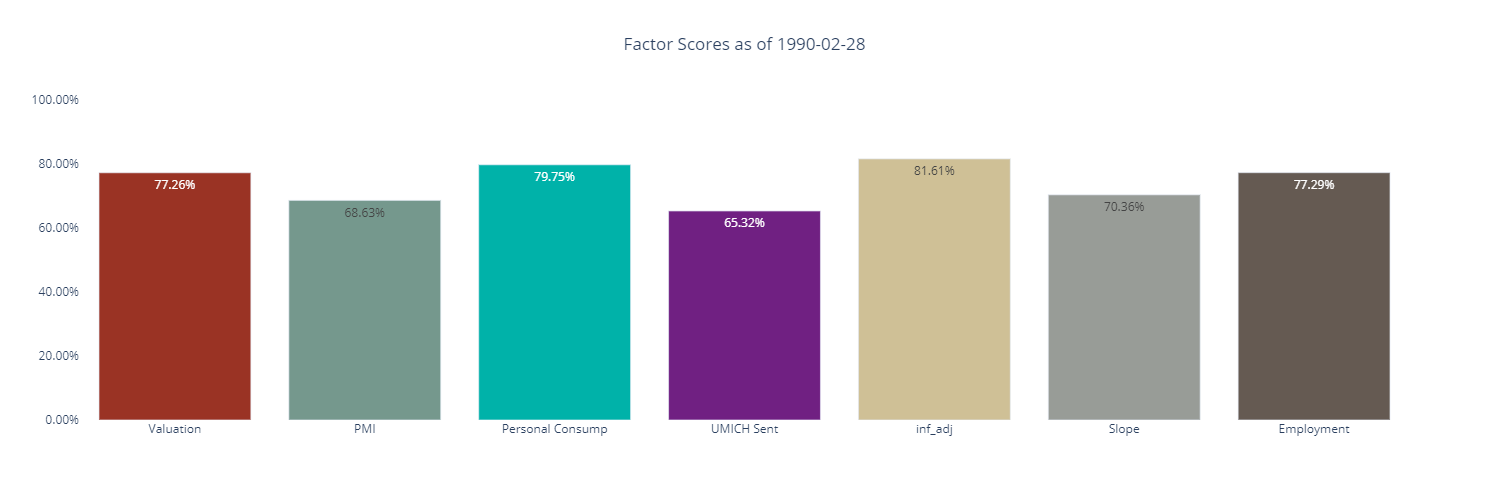

In [23]:
k['1990-02-28']